In [1]:
# Install required libs
!pip install -U segmentation-models-pytorch albumentations --user -qq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
!pip install --upgrade opencv-python

In [3]:
import albumentations as albu

In [4]:
#!pip uninstall -y segmentation-models-pytorch

## Loading data

In [5]:
from huggingface_hub import login

login("")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [6]:
hf_dataset_identifier = "mouadenna/satellite_PV_dataset_train_test_v1"

In [7]:
from datasets import load_dataset
from datasets import load_dataset

train_ds = dataset = load_dataset("parquet", data_dir="/kaggle/input/dataset-pv-kaggle/satellite_PV_train_augmentedx3_v2/data",split="train")
test_ds = dataset = load_dataset("parquet", data_dir="/kaggle/input/dataset-pv-kaggle/satellite_PV_dataset_train_test_v1/data",split="test")

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [8]:
train_ds

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 10998
})

In [9]:
#ds = ds.shuffle(seed=1)
train_ds = train_ds.shuffle(seed=1)
test_ds = test_ds.shuffle(seed=1)

In [10]:
import json
from huggingface_hub import hf_hub_download

filename = "id2label.json"
id2label = json.load(open("/kaggle/input/id2label-pv/id2label.json", "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)
print("Id2label:", id2label)

Id2label: {0: 'unlabeled', 1: 'PV'}


In [11]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [12]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [13]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [14]:
import numpy as np
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform=None, preprocessing=None, num_augmentations=1, is_train=True):
        self.dataset = dataset
        self.transform = transform
        self.preprocessing = preprocessing
        self.num_augmentations = num_augmentations
        self.is_train = is_train

    def __len__(self):
        if self.is_train:
            return len(self.dataset) * self.num_augmentations
        else:
            return len(self.dataset)

    def __getitem__(self, idx):
        if self.is_train:
            base_idx = idx // self.num_augmentations
            augmentation_idx = idx % self.num_augmentations

            image = np.array(self.dataset[base_idx]['pixel_values'])
            segmentation_map = np.array(self.dataset[base_idx]['label'])

            aug_image, aug_segmentation_map = image, segmentation_map

            if self.transform:
                transformed = self.transform(image=aug_image, mask=aug_segmentation_map)
                aug_image, aug_segmentation_map = transformed['image'], transformed['mask']

            if self.preprocessing:
                sample = self.preprocessing(image=aug_image, mask=aug_segmentation_map)
                aug_image, aug_segmentation_map = sample['image'], sample['mask']

            image = aug_image.transpose(2, 0, 1)
        else:
            image = np.array(self.dataset[idx]['pixel_values'])
            segmentation_map = np.array(self.dataset[idx]['label'])

            if self.transform:
                transformed = self.transform(image=image, mask=segmentation_map)
                image, segmentation_map = transformed['image'], transformed['mask']

            if self.preprocessing:
                sample = self.preprocessing(image=image, mask=segmentation_map)
                image, segmentation_map = sample['image'], sample['mask']

            image = image.transpose(2, 0, 1)
            
        return image, aug_segmentation_map if self.is_train else segmentation_map


In [15]:
# Lets look at data we have

dataset = CustomDataset(train_ds)


In [16]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        # Transpose the image tensor from (C, H, W) to (H, W, C) for display
        image = np.transpose(image, (1, 2, 0))  # Assuming image is a numpy array
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(name)
        plt.imshow(image)
    plt.show()


In [17]:
len(dataset[4][0])

3

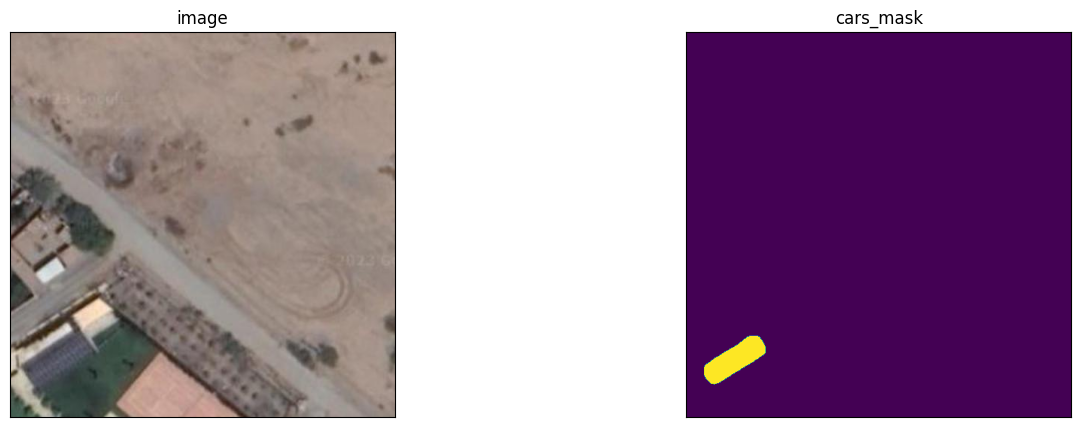

In [18]:
image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=np.expand_dims(mask, axis=0),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [19]:
MEAN = [0.45201411, 0.43259537, 0.43638059]
STD = [0.23993868, 0.20162842, 0.18709605]

In [20]:



def to_tensor(x, **kwargs):
    return x.astype('float32')#.transpose(2, 0, 1)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
        #albu.Normalize(mean=MEAN,std=STD)
    ]
    return albu.Compose(_transform)

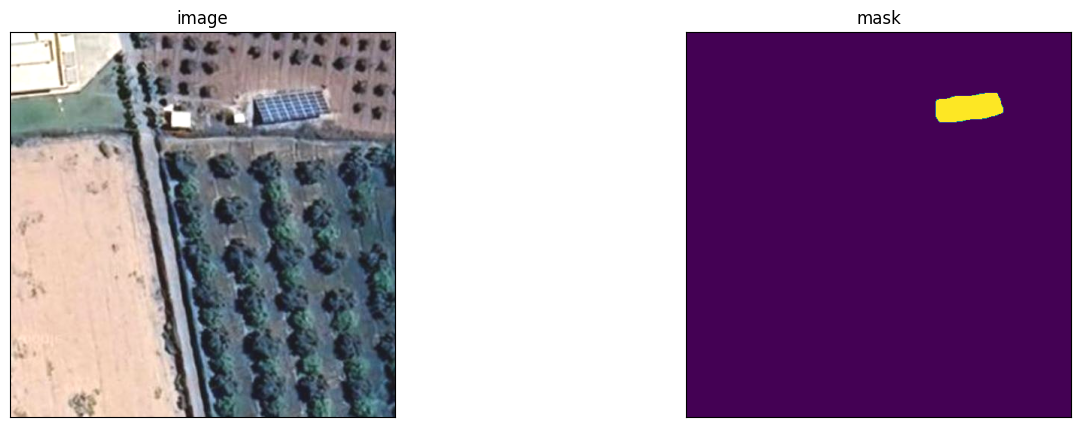

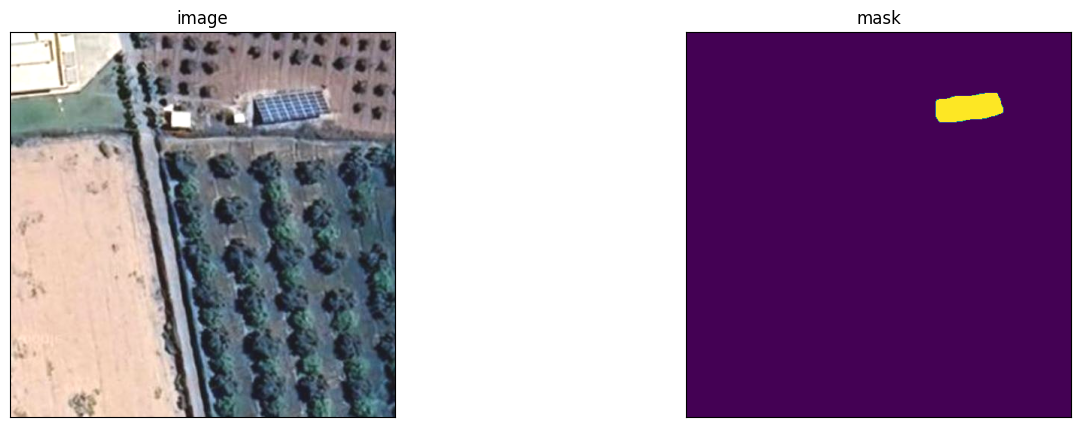

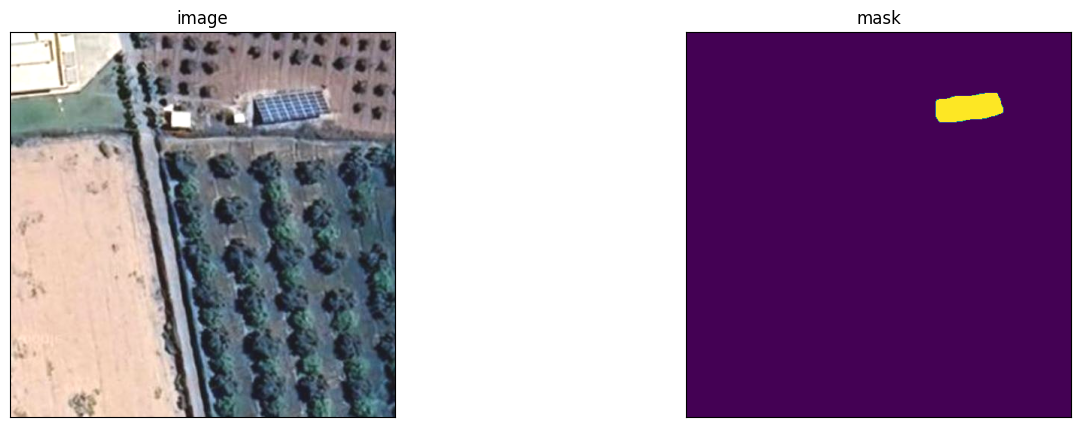

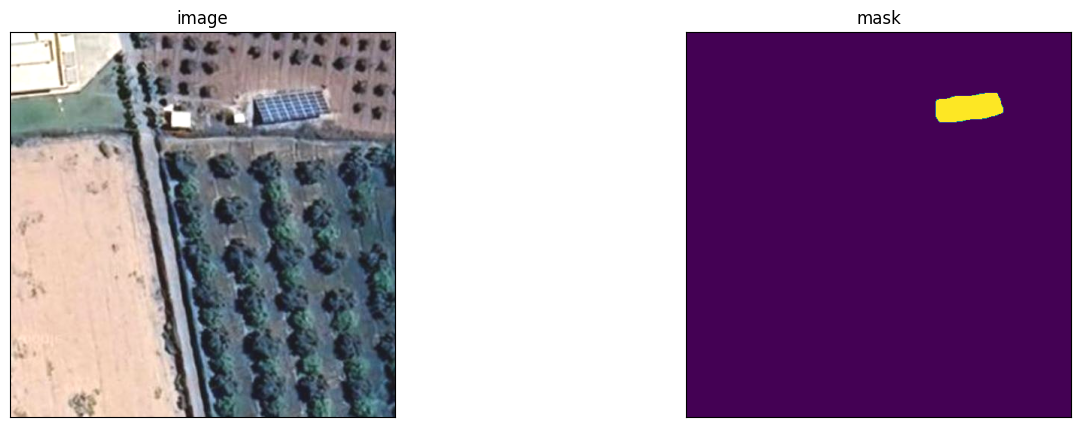

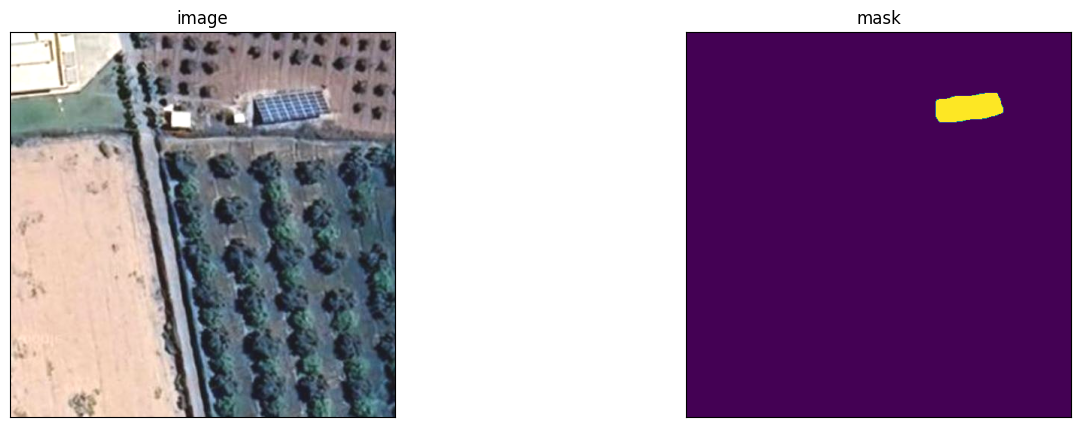

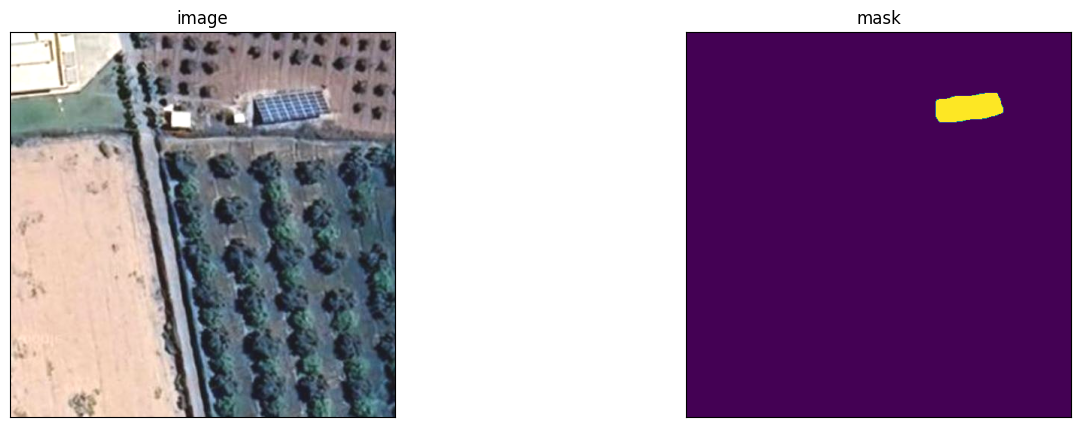

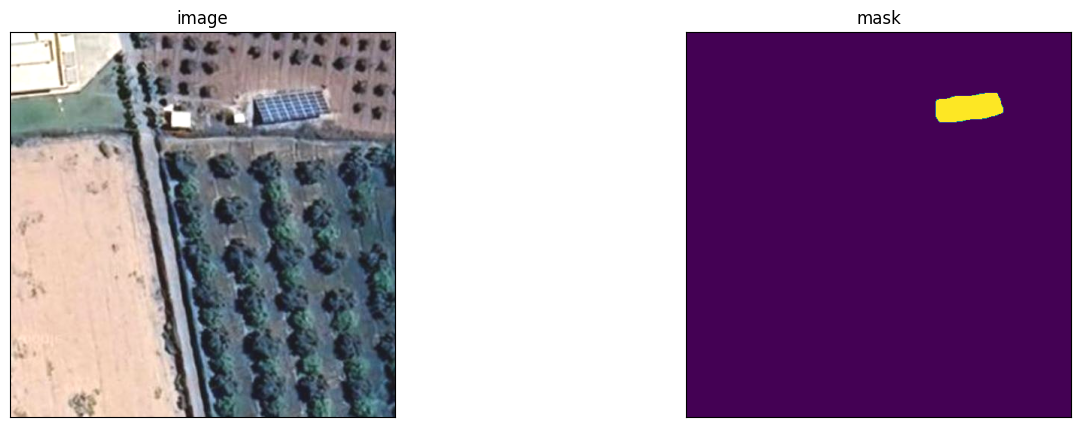

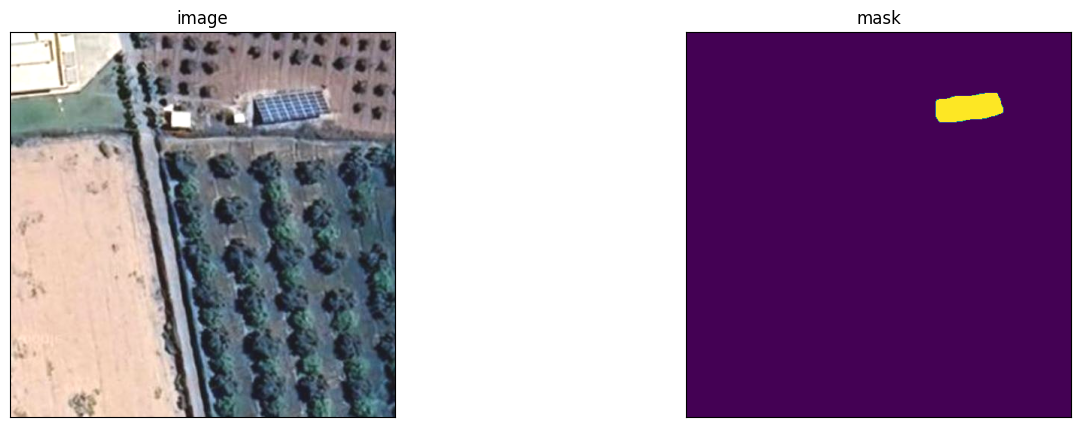

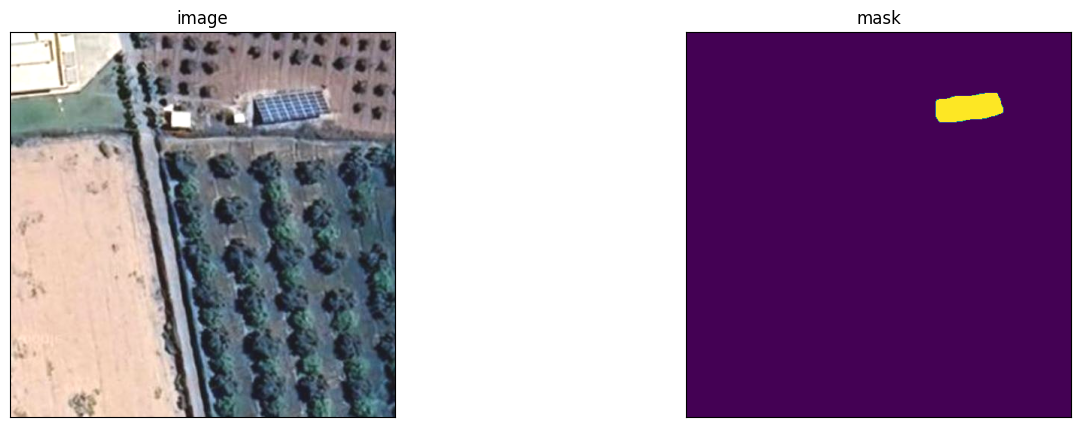

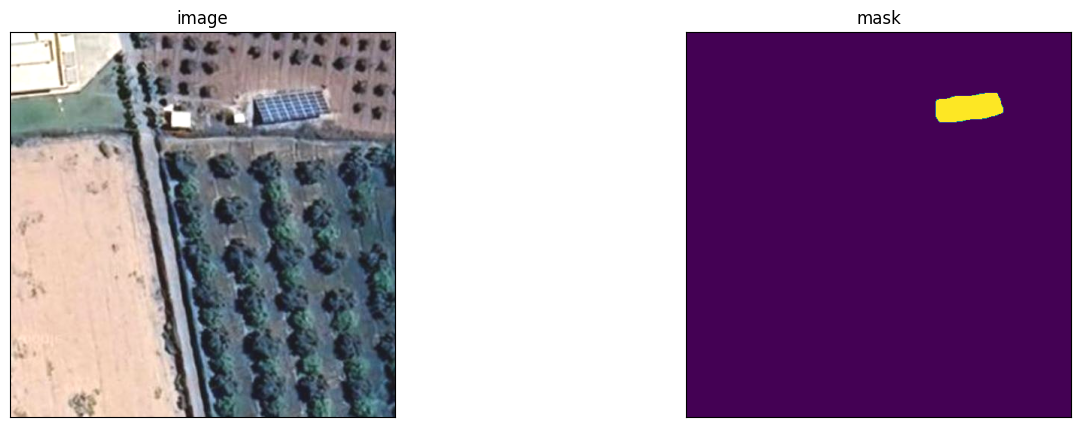

In [21]:
#### Visualize resulted augmented images and masks

augmented_dataset = CustomDataset(
    train_ds, 
    is_train=False
)

# same image with different random transforms
for i in range(10):
    image, mask = augmented_dataset[10]
    visualize(image=image, mask=np.expand_dims(mask, axis=0))

In [22]:
mask.shape

(512, 512)

## Create model and train

In [23]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [24]:
import ssl
import torch
import segmentation_models_pytorch as smp

# Bypass SSL verification
ssl._create_default_https_context = ssl._create_unverified_context

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['PV']
ACTIVATION = 'sigmoid'  # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /root/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth
100%|██████████| 105M/105M [05:10<00:00, 356kB/s]


In [25]:
train_dataset = CustomDataset(
    train_ds, 
    preprocessing=get_preprocessing(preprocessing_fn),
    is_train=False
)

valid_dataset = CustomDataset(
    test_ds,
    preprocessing=get_preprocessing(preprocessing_fn),
    is_train=False
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)

In [26]:
from segmentation_models_pytorch import utils

In [27]:
import segmentation_models_pytorch as smp
import torch

# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0005),
])

In [28]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [29]:
import torch

# Assuming train_loader is your DataLoader object
for batch in train_loader:
    images, masks = batch  # Assuming your DataLoader returns images and masks
    # Process or visualize a sample from the batch
    print("Image shape:", images.shape)
    print("Mask shape:", masks.shape)
    break  # Break after printing the first batch

# If your DataLoader is infinite, you might need to use itertools.cycle to get more samples


Image shape: torch.Size([4, 3, 512, 512])
Mask shape: torch.Size([4, 512, 512])


In [30]:
%%time
# train model for 40 epochs
max_score = 0
patience = 10
factor = 0.1
best_epoch = 0
EPOCHS=37

for i in range(EPOCHS):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # Save best model
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        best_epoch = i
        torch.save(model, './best_model.pth')
        print('Model saved!')
    
    if i - best_epoch >= patience:
        current_lr = optimizer.param_groups[0]['lr']
        new_lr = current_lr * factor
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
        print(f'Reducing learning rate from {current_lr} to {new_lr}')
        best_epoch = i  

    print(f'Current learning rate: {optimizer.param_groups[0]["lr"]}')


Epoch: 0
valid: 100%|██████████| 230/230 [00:33<00:00,  6.90it/s, dice_loss - 0.1033, iou_score - 0.8569, precision - 0.8821]
Model saved!
Current learning rate: 0.0005

Epoch: 1
valid: 100%|██████████| 230/230 [00:33<00:00,  6.91it/s, dice_loss - 0.08212, iou_score - 0.8858, precision - 0.9247]
Model saved!
Current learning rate: 0.0005

Epoch: 2
valid: 100%|██████████| 230/230 [00:33<00:00,  6.93it/s, dice_loss - 0.08336, iou_score - 0.8764, precision - 0.938]
Current learning rate: 0.0005

Epoch: 3
valid: 100%|██████████| 230/230 [00:33<00:00,  6.93it/s, dice_loss - 0.08757, iou_score - 0.8722, precision - 0.9239]
Current learning rate: 0.0005

Epoch: 4
valid: 100%|██████████| 230/230 [00:33<00:00,  6.91it/s, dice_loss - 0.06732, iou_score - 0.9045, precision - 0.9394]
Model saved!
Current learning rate: 0.0005

Epoch: 5
valid: 100%|██████████| 230/230 [00:33<00:00,  6.91it/s, dice_loss - 0.07315, iou_score - 0.9053, precision - 0.9368]
Model saved!
Current learning rate: 0.0005

E

## Test best saved model

In [31]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [32]:
# create test dataset
test_dataset = CustomDataset(
    test_ds,
    preprocessing=get_preprocessing(preprocessing_fn),
    is_train=False
)

test_dataloader =  DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)

In [33]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 230/230 [00:33<00:00,  6.90it/s, dice_loss - 0.04091, iou_score - 0.9502, precision - 0.953]


## Visualize predictions

In [34]:
# test dataset without transformations for image visualization
test_dataset_vis = CustomDataset(
    test_ds,
    preprocessing=get_preprocessing(preprocessing_fn),
    is_train=False
)

In [35]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        if image.ndim == 2:  # If the image is 2D (single channel)
            plt.subplot(1, n, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.title(name)
            plt.imshow(image, cmap='gray')
        else:  # If the image is 3D
            image = np.transpose(image, (1, 2, 0))  # Assuming image is a numpy array
            plt.subplot(1, n, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.title(name)
            plt.imshow(image)
    plt.show()


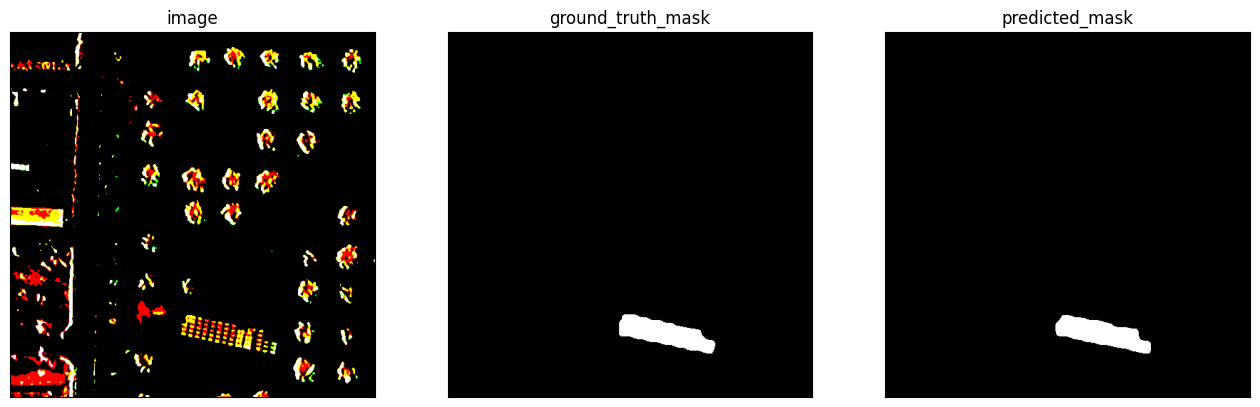

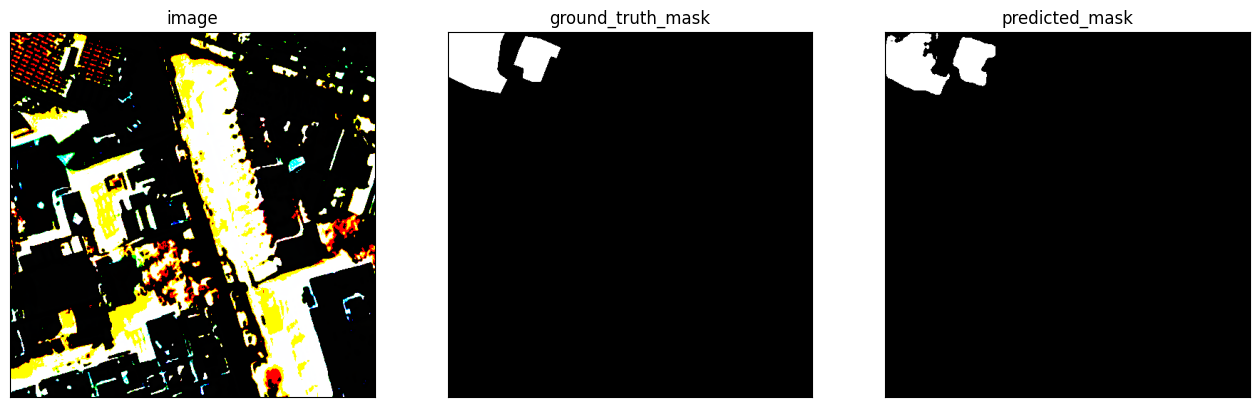

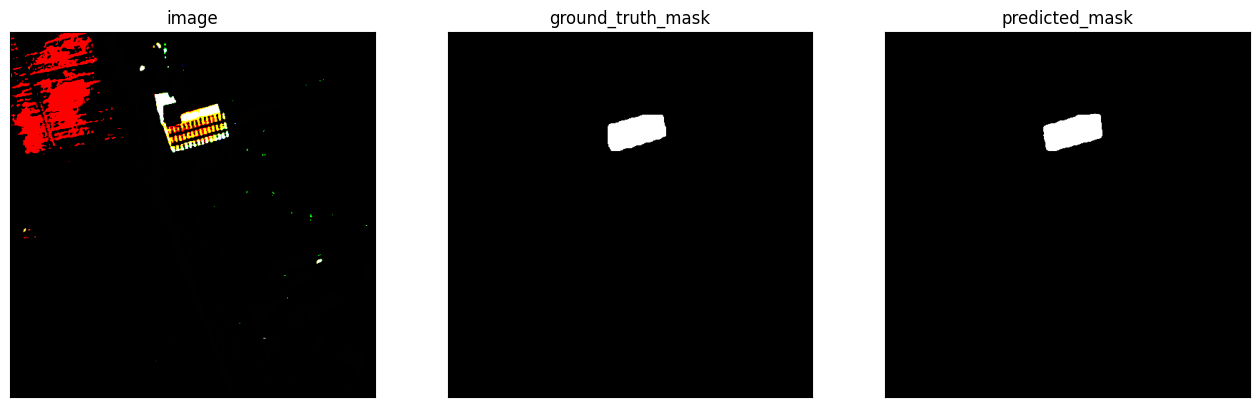

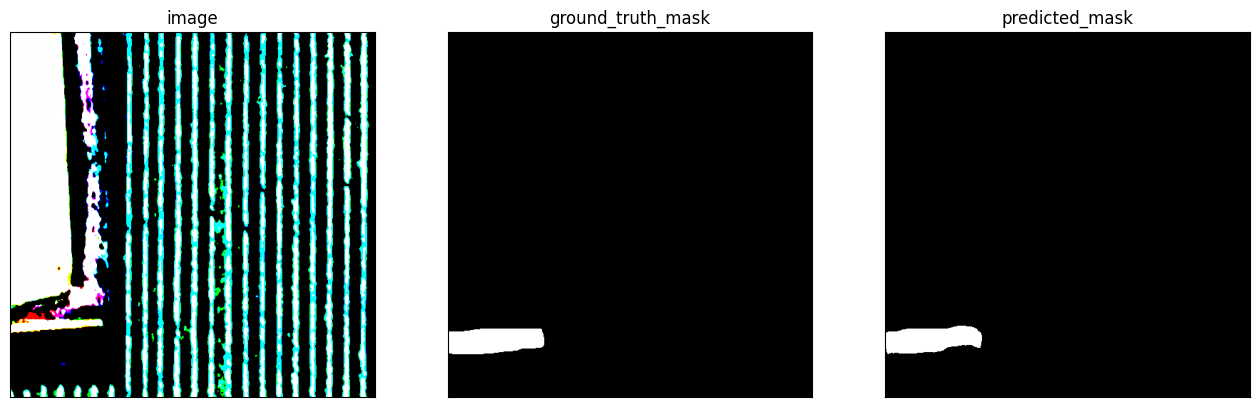

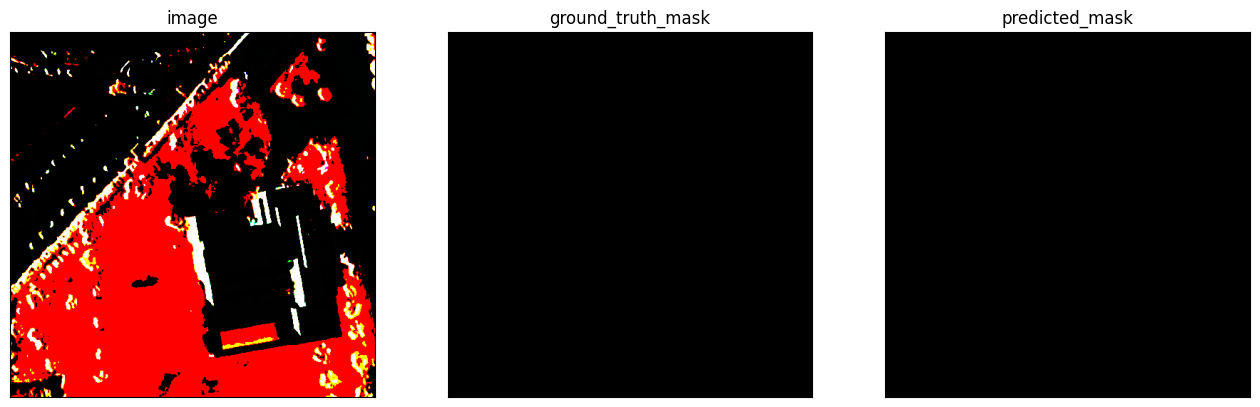

In [36]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )
